In [24]:
import os
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import functional as F

import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.datasets as datasets

data_dir = 'data'
image_dir = os.path.join(data_dir, 'jpeg')
train_dir = os.path.join(image_dir, 'train')
test_dir = os.path.join(image_dir, 'test')
train_class = os.path.join(data_dir, 'train.csv')
test_class = os.path.join(data_dir, 'test.csv')

image_data = {'train':train_dir, 'test':test_dir}
label_data = {'train':train_class, 'test':test_class}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
class Melanoma(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.skin_labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.skin_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.skin_labels.iloc[idx, 0])
        image = Image.open(img_name + '.jpg')
        
        if 'train' in self.root_dir:
            label = int(self.skin_labels.iloc[idx, 7])
        else:
            label = 0

        if self.transform:
            image = self.transform(image)

        return image, label
    

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [36]:
train_file = os.path.join(data_dir, 'train.pth')
val_file = os.path.join(data_dir, 'val.pth')

if os.path.isfile(train_file):
    train_dataset = torch.load(train_file)
else:
    dataset = Melanoma(label_data['train'], image_data['train'], 
                             transform=data_transforms['train'])
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [23126,10000])
    torch.save(train_dataset, train_file)
    torch.save(val_dataset, val_file)

val_dataset = torch.load(val_file)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

print("Finish Loading Datasets")
print("Number of training images: ", len(train_dataset))
print("Number of testing images: ", len(val_dataset))

Finish Loading Datasets
Number of training images:  23126
Number of testing images:  10000


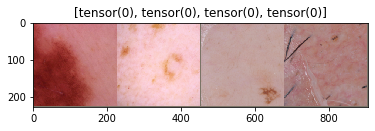

In [37]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x for x in classes])

In [66]:
resnet = models.resnet18(pretrained=True)
n_features = resnet.fc.in_features
resnet.fc = nn.Linear(n_features, 100)
'''model = nn.Sequential(OrderedDict([
          ('ResNet18', resnet),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(100, 2)),
          ('sigmoid', nn.sigmoid())
        ]))'''

model = nn.Sequential(
            resnet,
            nn.ReLU(),
            nn.Linear(100, 2))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
dataloaders = {'train':train_dataloader, 'val':val_dataloader}

In [73]:
import time 
import copy
from barbar import Bar

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in Bar(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = torch.sigmoid(model(inputs))
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
 4716/23126: [======>.........................] - ETA 4700.5s